# Compare Implied Storage (Test Data) For Rule Based Model vs. LSTM Model 1

In [1]:
import os
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.train_model import *
from src.models.analyze_lstm_cell import *
from src.data.implied_storage import get_implied_storage

from ssjrb_wrapper.model_wrapper import reservoir_model
from ssjrb_wrapper.util import read_historical_df
from ssjrb_wrapper.util import water_day
from ssjrb_wrapper.train_preprocess import train_medians

## Model 1

In [3]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

### Standardized Data

In [ ]:
# Run data processing pipeline
pipeline_std = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1)
# Train/val/test of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
ts_train_std, ts_val_std, ts_test_std = pipeline_std.process_data(df) 

# Separate inputs(X) and targets (y)
# Select inflow and doy as input features
X_train_std, X_val_std, X_test_std = ts_train_std[:, :, [0, 3]], ts_val_std[:, :, [0, 3]], ts_test_std[:, :, [0, 3]]
# Select outflow as target feature
y_train_std, y_val_std, y_test_std = ts_train_std[:, :, [1]], ts_val_std[:, :, [1]], ts_test_std[:, :, [1]]

In [ ]:
# Check lengths of train/val/test sets
original_train_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline_std.train_frac))
original_val_len = int(round(df['1944-01-01':'2022-12-31'].shape[0] * pipeline_std.val_frac))
original_test_len = df['1944-01-01':'2022-12-31'].shape[0] - (original_train_len + original_val_len)

### Load Model 1 and Get Output Predictions 

In [6]:
# instantiate optimal model
input_size = 2
hidden_size1 = 30
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3
num_layers = 1
torch.manual_seed(0)
model1 = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers,
                             dropout_prob=dropout_prob)
# load saved model
model1.load_state_dict(torch.load('src/models/saved_models/model1a.pt'))
# turn model into evaluation model
model1.eval()

C:\Users\mattc\AppData\Local\Temp\ipykernel_7020\2474459162.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('src/models/saved_models/m

LSTMModel1(
  (lstm_cell_list): ModuleList(
    (0): LSTMCell(2, 30)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (linear1): Linear(in_features=30, out_features=15, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=15, out_features=1, bias=True)
)

In [7]:
# Get predicted outflow states
from src.models.predict_model import *
outflow_hat_train = flatten_rm_pad(predict(model=model1, x=X_train_std),
                                   y_train_std)[0].detach().numpy()
outflow_hat_val = flatten_rm_pad(predict(model=model1, x=X_val_std),
                                   y_val_std)[0].detach().numpy()
outflow_hat_test = flatten_rm_pad(predict(model=model1, x=X_test_std),
                                   y_test_std)[0].detach().numpy()
assert outflow_hat_train.shape[0] == original_train_len

In [8]:
# Get observed inflow states, shape is (timesteps, )
inflow_train = df.inflow[:original_train_len].values
inflow_val = df.inflow[original_train_len:(original_train_len+original_val_len)].values
inflow_test = df.inflow[(original_train_len+original_val_len):].values

# Get observed outflow states, shape is (timesteps, )
outflow_train = df.outflow[:original_train_len].values
outflow_val = df.outflow[original_train_len:(original_train_len+original_val_len)].values
outflow_test = df.outflow[(original_train_len+original_val_len):].values

# Get observed storage states, shape is (timesteps, )
storage_train = df.storage[:original_train_len].values
storage_val = df.storage[original_train_len:(original_train_len+original_val_len)].values
storage_test = df.storage[(original_train_len+original_val_len):].values

### Unscale Outflow Predictions, Convert CFS to AF, Get Implied Storage

In [9]:
def unscale_series(x, train_data):
    """ 
    Unscale standardized input series based on training data statistics.
    Params: x - input numpy array, 
            train_data - training data used for scaling
    """
    return (x * train_data[~np.isnan(train_data)].std()) + train_data[~np.isnan(train_data)].mean()

In [10]:
# Undo scaling of predicted outflow, convert cfs to af
outflow_hat_test1 = unscale_series(outflow_hat_test, train_data=outflow_train) # in cfs, outflow_hat_test already has pads removed
outflow_hat_test1_af = outflow_hat_test1 * 86400 / 43559.9 # convert to acre-feet: (86400 seconds in a day, 43559.9 cfs in an acre-foot)
inflow_test_af = inflow_test * 86400 / 43559.9
inflow_test_af = pd.Series(inflow_test_af).fillna(inflow_train.mean() * 86400 / 43559.9).values # Fill NaN in observed inflow with training mean
assert outflow_hat_test1.shape[0] == original_test_len & inflow_test_af.shape[0] == original_test_len

# Calculate implied storage
implied_storage_test_model1 = get_implied_storage(inflow=inflow_test_af, 
                                                  outflow=outflow_hat_test1_af, 
                                                  initial_storage=storage_val[-1], 
                                                  initial_release=outflow_val[-1] * 86400 / 43559.9)

## Model 1-S

In [11]:
## Input data with storage included
X_train_sto, X_val_sto, X_test_sto = ts_train_std[:, :, [0, 2, 3]], ts_val_std[:, :, [0, 2, 3]], ts_test_std[:, :, [0, 2, 3]]

## Instantiate storage model
input_size = 3
hidden_size1 = 30
hidden_size2 = 15
output_size = 1
dropout_prob = 0.3
num_layers = 1
torch.manual_seed(0)
model1S = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, hidden_size2=hidden_size2, output_size=output_size, 
                          num_layers=num_layers, dropout_prob=dropout_prob)


## Fit model
# Create PyTorch Dataset and Dataloader
dataset_train, dataset_val = (TensorDataset(X_train_sto, y_train_std), TensorDataset(X_val_sto, y_val_std))
dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                    DataLoader(dataset_val, batch_size=1, shuffle=False))
criterion = nn.MSELoss()
optimizer = optim.Adam(model1S.parameters(), lr=0.001)
# Run training loop
train_losses, val_losses = training_loop(model=model1S, criterion=criterion, optimizer=optimizer, 
                                        patience=10, dataloader_train=dataloader_train, 
                                        dataloader_val=dataloader_val, epochs=1000)

## Get predicted outflow states
outflow_hat_train1S = flatten_rm_pad(predict(model=model1S, x=X_train_sto),
                                   y_train_std)[0].detach().numpy()
outflow_hat_val1S = flatten_rm_pad(predict(model=model1S, x=X_val_sto),
                                   y_val_std)[0].detach().numpy()
outflow_hat_test1S = flatten_rm_pad(predict(model=model1S, x=X_test_sto),
                                   y_test_std)[0].detach().numpy()
assert outflow_hat_train1S.shape[0] == original_train_len

## Undo scaling of predicted outflow, convert cfs to af
outflow_hat_test_model1S = unscale_series(outflow_hat_test1S, train_data=outflow_train) # in cfs, outflow_hat_test already has pads removed
outflow_hat_test_model1S_af = outflow_hat_test_model1S * 86400 / 43559.9 # convert to acre-feet: (86400 seconds in a day, 43559.9 cfs in an acre-foot)
assert outflow_hat_test_model1S.shape[0] == original_test_len

# Calculate implied storage
implied_storage_test_model1S = get_implied_storage(inflow=inflow_test_af, 
                                                  outflow=outflow_hat_test_model1S_af, 
                                                  initial_storage=storage_val[-1], 
                                                  initial_release=outflow_val[-1] * 86400 / 43559.9)

Training epochs:   8%|▊         | 77/1000 [00:04<00:57, 15.98it/s]


## Model 3

In [12]:
## Instantiate model
input_size = 2
hidden_size1 = 35
hidden_size2 = 15
num_layers = 1
output_size = 1
dropout_prob = 0.3

torch.manual_seed(0)
model3 = LSTMModel3(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob, initial_output=0, initial_implied_storage=0)

## Load saved model parameters
model3.load_state_dict(torch.load('src/models/saved_models/model3a.pt'))

## Get predicted outflow states
from src.models.predict_model import *
outflow_hat_train3 = flatten_rm_pad(predict(model=model3, x=X_train_std),
                                   y_train_std)[0].detach().numpy()
outflow_hat_val3 = flatten_rm_pad(predict(model=model3, x=X_val_std),
                                   y_val_std)[0].detach().numpy()
outflow_hat_test3 = flatten_rm_pad(predict(model=model3, x=X_test_std),
                                   y_test_std)[0].detach().numpy()
assert outflow_hat_train3.shape[0] == original_train_len

## Undo scaling of predicted outflow, convert cfs to af
outflow_hat_test_model3 = unscale_series(outflow_hat_test3, train_data=outflow_train) # in cfs, outflow_hat_test already has pads removed
outflow_hat_test_model3_af = outflow_hat_test_model3 * 86400 / 43559.9 # convert to acre-feet: (86400 seconds in a day, 43559.9 cfs in an acre-foot)
assert outflow_hat_test_model3.shape[0] == original_test_len

# Calculate implied storage
implied_storage_test_model3 = get_implied_storage(inflow=inflow_test_af, 
                                                  outflow=outflow_hat_test_model3_af, 
                                                  initial_storage=storage_val[-1], 
                                                  initial_release=outflow_val[-1] * 86400 / 43559.9)

C:\Users\mattc\AppData\Local\Temp\ipykernel_7020\3335797198.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model3.load_state_dict(torch.load('src/models/saved_models/m

## Model 4

In [13]:
## Instantiate model
input_size = 2
hidden_size = 50
output_size = 1
dropout_prob = 0.7
torch.manual_seed(0)
model4 = resRNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
               dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model4.parameters(), lr=0.001)

# load saved model
model4.load_state_dict(torch.load('src/models/saved_models/resRNN.pt'))

## Get predicted outflow states
from src.models.predict_model import *
outflow_hat_train4 = flatten_rm_pad(predict(model=model4, x=X_train_std),
                                   y_train_std)[0].detach().numpy()
outflow_hat_val4 = flatten_rm_pad(predict(model=model4, x=X_val_std),
                                   y_val_std)[0].detach().numpy()
outflow_hat_test4 = flatten_rm_pad(predict(model=model4, x=X_test_std),
                                   y_test_std)[0].detach().numpy()
assert outflow_hat_train4.shape[0] == original_train_len

## Undo scaling of predicted outflow, convert cfs to af
outflow_hat_test_model4 = unscale_series(outflow_hat_test4, train_data=outflow_train) # in cfs, outflow_hat_test already has pads removed
outflow_hat_test_model4_af = outflow_hat_test_model4 * 86400 / 43559.9 # convert to acre-feet: (86400 seconds in a day, 43559.9 cfs in an acre-foot)
assert outflow_hat_test_model4.shape[0] == original_test_len

# Calculate implied storage
implied_storage_test_model4 = get_implied_storage(inflow=inflow_test_af, 
                                                  outflow=outflow_hat_test_model4_af, 
                                                  initial_storage=storage_val[-1], 
                                                  initial_release=outflow_val[-1] * 86400 / 43559.9)

C:\Users\mattc\AppData\Local\Temp\ipykernel_7020\2902975487.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model4.load_state_dict(torch.load('src/models/saved_models/r

## Rule Based Model

### Fit Rule Based Model

In [14]:
def fit_one_reservoir(name, left, right = '2022-12-31'):
    """
    Fit SSJRB reservoir model to a single reservoir for USBR data

    Params:
    res_id -- str, Reservoir ID to fit model to
    left -- str (datelike), left window date to fetch data from
    right -- str (datelike), right window date to fetch data from

    Returns:
    model -- fitted SSJRB model
    r2_scores -- df of outflow r2 scores for train/val/test splits
    """

    ### DATA PROCESSING

    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Select left-right window
    df = df[left:right].copy()

    # Rename columns to work with SSJRB wrapper
    df[f'{name}_inflow_cfs'] = df['inflow']
    df[f'{name}_outflow_cfs'] = df['outflow']
    df[f'{name}_storage_af'] = df['storage']

    # Add DOWY column
    doy_series = df.index.to_series().dt.dayofyear
    df['dowy'] = [water_day(i) for i in doy_series]

    # Train/val/test split
    df_train, df_val, df_test = train_val_test(df, train_frac=0.6, val_frac=0.2, test_frac=0.2)

    # Fill missing values with mean of training data
    train_mean = df_train.mean()
    df_train = df_train.fillna(train_mean)
    df_val = df_val.fillna(train_mean)
    df_test = df_test.fillna(train_mean)


    ### MODEL TRAINING

    # Capacity (take as max of training storage series)
    training_capacity = df_train[f'{name}_storage_af'].max() / 1000 # units = TAF
    capacity_dict = {name: training_capacity}

    # Instantiate model
    model_i = reservoir_model(reservoir_capacity = capacity_dict)
    # Fit with early stopping on validation data
    model_i.fit(df_train=df_train, df_val=df_val, patience=5)

    ### EVALUATE MODEL AND SAVE PARAMS

    # Get predictions from fitted model, evaluate r2 score
    df_hat_train, df_hat_val, df_hat_test = (model_i.predict(df = df_train),
                                            model_i.predict(df = df_val),
                                            model_i.predict(df = df_test))

    r2_scores = pd.DataFrame({'train': r2_score(df_train[f'{name}_outflow_cfs'], df_hat_train[f'{name}_outflow_cfs']),
                            'val': r2_score(df_val[f'{name}_outflow_cfs'], df_hat_val[f'{name}_outflow_cfs']),
                            'test': r2_score(df_test[f'{name}_outflow_cfs'], df_hat_test[f'{name}_outflow_cfs'])}, index=[name])

    # # Save model parameters
    # model_i.save_params(filepath='./results/saved_models/resops_ssjrb_reservoir', fileprefix=f'resops_ssjrb_model_{res_id}')

    return model_i, r2_scores

In [15]:
# Fit rule based model to Shasta reservoir
rule_model, rule_r2_scores = fit_one_reservoir(name='Shasta', left='1944-01-01', right='2022-12-31')
rule_r2_scores

Shasta: train score=14226278, val score: 18017592, NFE = 1659, Message: Early stopping triggered


,train,val,test
Shasta,0.685683,0.680901,0.655923


### Get Outflow Predictions, Convert CFS to AF, Get Implied Storage

In [16]:
# Rename columns to work with SSJRB wrapper
df[f'Shasta_inflow_cfs'] = df['inflow']
df[f'Shasta_outflow_cfs'] = df['outflow']
df[f'Shasta_storage_af'] = df['storage']

# Add DOWY column
doy_series = df.index.to_series().dt.dayofyear
df['dowy'] = [water_day(i) for i in doy_series]

# Train/val/test split
df_train, df_val, df_test = train_val_test(df, train_frac=0.6, val_frac=0.2, test_frac=0.2)

# Fill missing values with mean of training data
train_mean = df_train.mean()
df_train = df_train.fillna(train_mean)
df_val = df_val.fillna(train_mean)
df_test = df_test.fillna(train_mean)

# Get prediction from test data
outflow_hat_test_rule = rule_model.predict(df=df_test)['Shasta_outflow_cfs'].values
outflow_hat_test_rule_af = outflow_hat_test_rule * 86400 / 43559.9  # convert to cfs to af
assert outflow_hat_test_rule_af.shape[0] == original_test_len

# Calculate implied storage for rule based model
implied_storage_test_rule = get_implied_storage(inflow=inflow_test_af, 
                                                outflow=outflow_hat_test_rule_af, 
                                                initial_storage=storage_val[-1], 
                                                initial_release=outflow_val[-1] * 86400 / 43559.9)

## Plot Implied vs Observed Storage for Both Models

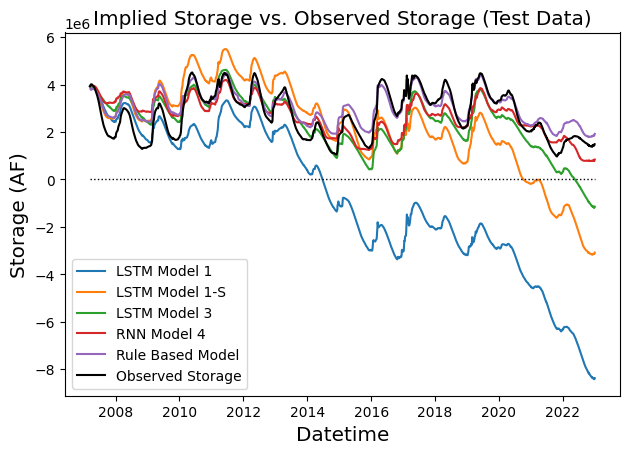

In [17]:
fig, ax = plt.subplots()
ax.plot(df_test.index, implied_storage_test_model1, label='LSTM Model 1')
ax.plot(df_test.index, implied_storage_test_model1S, label='LSTM Model 1-S')
ax.plot(df_test.index, implied_storage_test_model3, label='LSTM Model 3')
ax.plot(df_test.index, implied_storage_test_model4, label='RNN Model 4')
ax.plot(df_test.index, implied_storage_test_rule, label='Rule Based Model')
ax.plot(df_test.index, storage_test, color='black', linestyle="-", label='Observed Storage')

ax.hlines(y=0, xmin=df_test.index.min(), xmax=df_test.index.max(), color='k', linestyle=':', linewidth=1)

ax.set_title('Implied Storage vs. Observed Storage (Test Data)', size='x-large')
ax.set_xlabel('Datetime', size='x-large')
ax.set_ylabel('Storage (AF)', size='x-large')
ax.legend()
plt.tight_layout()
plt.savefig('report/drafting/8_15_2025/Figures/implied_storage_comparison.png', dpi=300)
plt.show()